In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
val_chr = ['chr10', 'chr16', 'chr18', 'chr15', 'chr19', 'chr20', 'chr21', 'chr22']
EH_header = ['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'LP6005616-DNA_A03']
val_samples = ['HG01243', 'HG01891', 'HG02257', 'HG02630', 'HG03098', 'HG03492', 'NA19240']
TRGT_header = ['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'sample']
CHR = [ item.split("_")[0] for item in pd.read_csv("output/trgt/eh_repeatregions.txt", sep=" ", names=["chr", "loc"])["loc"].tolist() ]
START = [ item.split("_")[1] for item in pd.read_csv("output/trgt/eh_repeatregions.txt", sep=" ", names=["chr", "loc"])["loc"].tolist() ]

In [7]:
eh_merged_df = pd.read_csv(f'./raw/eh/{val_samples[0]}.vcf', names=EH_header, sep="\t", comment='#')
eh_merged_df = eh_merged_df[eh_merged_df["#CHROM"].isin(val_chr)]
eh_merged_df = eh_merged_df[(eh_merged_df["#CHROM"].isin(CHR) & eh_merged_df["POS"].astype(str).isin(START))]

diff = []
for alt in eh_merged_df.ALT:
    alleles = []
    for a in alt.split(","):  # [<STR1>, <STR2>, <STR3>]
        if a == ".":
            alleles.append(0)
            break
        a = a.strip("<").strip(">").split("STR")[1]  # 1
        a = int(a)
        alleles.append(a)
    diff.append(max(alleles))

diff = np.asarray(diff, dtype=int)
end = np.asarray([ info.split(";")[0].split("=")[1] for info in eh_merged_df.INFO ], dtype=int)
start = np.asarray(eh_merged_df.POS.tolist(), dtype=int)
unit_length = np.asarray([ len( info.split(";")[3].split("=")[1] ) for info in eh_merged_df.INFO ], dtype=int)
counts = np.asarray([
    diff[i] if diff[i] > 0 else (end[i] - start[i]) / unit_length[i]
    for i in range(eh_merged_df.shape[0])
], dtype=int)
eh_len = counts * unit_length
#eh_len = counts
eh_merged_df = eh_merged_df[["#CHROM", "POS"]]
eh_merged_df['EH_LEN'] = eh_len
eh_merged_df.head()
print(eh_merged_df.shape[0])
print(eh_merged_df.head())

30492
      #CHROM    POS  EH_LEN
97847  chr10  72978      10
97848  chr10  81321      58
97849  chr10  84193      18
97850  chr10  89250      40
97851  chr10  93776      44


In [8]:
trgt_merged_df = pd.read_csv(f'output/trgt/{val_samples[0]}.hifi.sorted.vcf.gz', names=TRGT_header, compression="gzip", sep="\t", comment='#')
trgt_merged_df.head()
motif = [info.split(";")[2].split("=")[1].split(",")[0] for info in trgt_merged_df.INFO]
trgt_merged_df.head()

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,sample
0,chr1,44836,.,AAATAAATAAATAAATAAATAAATAAATAAAT,.,0,.,TRID=chr1_44835_44867;END=44867;MOTIFS=AAAT;ST...,GT:AL:ALLR:SD:MC:MS:AP:AM,"0/0:32,32:31-32,32-32:24,0:8,8:0(0-32),0(0-32)..."
1,chr1,151102,.,CTCT,.,0,.,TRID=chr1_151101_151105;END=151105;MOTIFS=CT;S...,GT:AL:ALLR:SD:MC:MS:AP:AM,.:.:.:.:.:.:.:.
2,chr1,165955,.,AATAAATA,.,0,.,TRID=chr1_165954_165962;END=165962;MOTIFS=AATA...,GT:AL:ALLR:SD:MC:MS:AP:AM,"0/0:8,8:8-8,8-8:5,0:2,2:0(0-8),0(0-8):1,1:.,."
3,chr1,167135,.,TTTATTTATTTATTTA,.,0,.,TRID=chr1_167134_167150;END=167150;MOTIFS=TTTA...,GT:AL:ALLR:SD:MC:MS:AP:AM,"0/0:16,16:16-16,16-16:6,0:4,4:0(0-16),0(0-16):..."
4,chr1,370633,.,TTTCTTTCTTTCTTTC,.,0,.,TRID=chr1_370632_370648;END=370648;MOTIFS=TTTC...,GT:AL:ALLR:SD:MC:MS:AP:AM,"0/0:16,16:11-16,16-16:14,0:4,4:0(0-16),0(0-16)..."


In [9]:
RANGE = 10

trgt_merged_df = pd.read_csv(f'output/trgt/{val_samples[0]}.hifi.sorted.vcf.gz', names=TRGT_header, compression="gzip", sep="\t", comment='#')
trgt_merged_df = trgt_merged_df[trgt_merged_df["#CHROM"].isin(val_chr)]
#trgt_merged_df = trgt_merged_df[(trgt_merged_df["#CHROM"].isin(CHR) & trgt_merged_df["POS"].astype(str).isin(START))]
start_df = pd.DataFrame({
    "#CHROM": CHR,
    "START": START,
})
df = pd.merge(trgt_merged_df, start_df, on="#CHROM", how='inner')
df = df[(df['POS'] >= df['START'].astype(int) - RANGE) & (df['POS'] <= df['START'].astype(int) + RANGE)]
df['POS'] = df['START'].astype(str)
trgt_merged_df = df.copy()

end = np.asarray([ info.split(";")[1].split("=")[1] for info in trgt_merged_df.INFO ], dtype=int)
start = np.asarray(trgt_merged_df.POS.tolist(), dtype=int)


trgt_len = [ len(alt) if alt != "."  else len(trgt_merged_df.REF.iloc[i]) for (i, alt) in enumerate(trgt_merged_df.ALT) ]
motif_len = [len(info.split(";")[2].split("=")[1].split(",")[0]) for info in trgt_merged_df.INFO]

trgt_merged_df = trgt_merged_df[["#CHROM", "POS"]]
#trgt_merged_df['TRGT_LEN'] = [trgt_len[i] / motif_len[i] for i in range(len(trgt_len))]
trgt_merged_df['TRGT_LEN'] = trgt_len

print(trgt_merged_df.shape[0])
print(trgt_merged_df.head())

30488
      #CHROM    POS  TRGT_LEN
7879   chr10  72978        11
13299  chr10  81321       103
18363  chr10  84193        18
23540  chr10  89250        73
28679  chr10  93776        44


In [10]:
trgt_merged_df['POS'] = trgt_merged_df['POS'].astype(str)
eh_merged_df['POS'] = eh_merged_df['POS'].astype(str)
big_df = pd.merge(eh_merged_df, trgt_merged_df, on=['#CHROM', 'POS'], how='inner')

In [11]:
for sample in val_samples[1:]:
    eh_df = pd.read_csv(f'./raw/eh/{sample}.vcf', names=EH_header, sep="\t", comment='#')
    eh_df = eh_df[eh_df["#CHROM"].isin(val_chr)]
    eh_df = eh_df[(eh_df["#CHROM"].isin(CHR) & eh_df["POS"].astype(str).isin(START))]

    diff = []
    for alt in eh_df.ALT:
        alleles = []
        #print(alt)
        for a in alt.split(","):  # [<STR1>, <STR2>, <STR3>]
            if a == ".":
                alleles.append(0)
                break
            a = a.strip("<").strip(">").split("STR")[1]  # 1
            a = int(a)
            alleles.append(a)
        diff.append(max(alleles))

    diff = np.asarray(diff, dtype=int)
    end = np.asarray([ info.split(";")[0].split("=")[1] for info in eh_df.INFO ], dtype=int)
    start = np.asarray(eh_df.POS.tolist(), dtype=int)
    unit_length = np.asarray([ len( info.split(";")[3].split("=")[1] ) for info in eh_df.INFO ], dtype=int)

    counts = np.asarray([
        diff[i] if diff[i] > 0 else (end[i] - start[i]) / unit_length[i]
        for i in range(eh_df.shape[0])
    ], dtype=int)
    
    eh_len = counts * unit_length
    #eh_len = counts
    eh_df = eh_df[["#CHROM", "POS"]]
    eh_df['EH_LEN'] = eh_len
    #eh_merged_df = pd.concat([eh_merged_df, eh_df], axis=0, ignore_index=True)
    
    trgt_df = pd.read_csv(f'output/trgt/{sample}.hifi.sorted.vcf.gz', names=TRGT_header, compression="gzip", sep="\t", comment='#')
    trgt_df = trgt_df[trgt_df["#CHROM"].isin(val_chr)]
    
    start_df = pd.DataFrame({
        "#CHROM": CHR,
        "START": START,
    })
    df = pd.merge(trgt_df, start_df, on="#CHROM", how='inner')
    df = df[(df['POS'] >= df['START'].astype(int) - RANGE) & (df['POS'] <= df['START'].astype(int) + RANGE)]
    df['POS'] = df['START'].astype(str)
    trgt_df = df.copy()

    end = np.asarray([ info.split(";")[1].split("=")[1] for info in trgt_df.INFO ], dtype=int)
    start = np.asarray(trgt_df.POS.tolist(), dtype=int)
    trgt_len = [ len(alt) if alt != "."  else len(trgt_df.REF.iloc[i]) for (i, alt) in enumerate(trgt_df.ALT) ]
    motif_len = [len(info.split(";")[2].split("=")[1].split(",")[0]) for info in trgt_df.INFO]
    
    #trgt_len = [trgt_len[i] / motif_len[i] for i in range(len(trgt_len))]
    trgt_df = trgt_df[["#CHROM", "POS"]]
    trgt_df['TRGT_LEN'] = trgt_len
    #trgt_merged_df = pd.concat([trgt_merged_df, trgt_df], axis=0, ignore_index=True)
    
    trgt_df['POS'] = trgt_df['POS'].astype(str)
    eh_df['POS'] = eh_df['POS'].astype(str)
    big_df = pd.concat([big_df, pd.merge(eh_df, trgt_df, on=['#CHROM', 'POS'], how='inner')], axis=0, ignore_index=True)

In [12]:
print(df.shape)
big_df.head()

(30488, 11)


,#CHROM,POS,EH_LEN,TRGT_LEN
0,chr10,72978,10,11
1,chr10,81321,58,103
2,chr10,84193,18,18
3,chr10,89250,40,73
4,chr10,93776,44,44


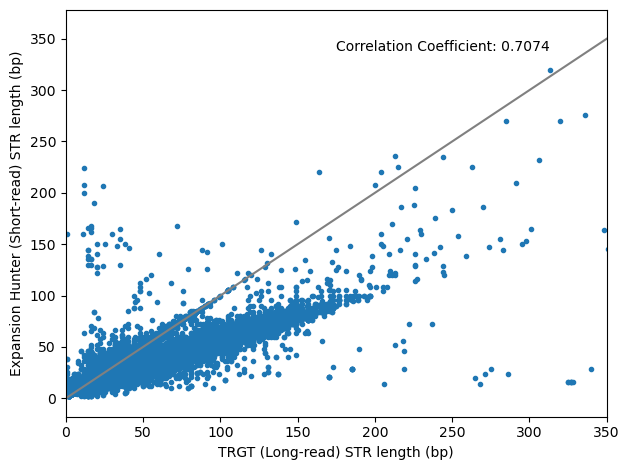

0.707364407799979


In [14]:
correlation_coefficient = np.corrcoef(big_df.TRGT_LEN, big_df.EH_LEN)[0, 1]
plt.scatter(big_df.TRGT_LEN, big_df.EH_LEN, marker='.', color='tab:blue', alpha=1)
plt.xlabel('TRGT (Long-read) STR length (bp)')
plt.ylabel('Expansion Hunter (Short-read) STR length (bp)')
#plt.xlabel('TRGT (Long-read) motif counts')
#plt.ylabel('Expansion Hunter (Short-read) motif counts')
plt.text(0.5, 0.9, f'Correlation Coefficient: {correlation_coefficient:.4f}', transform=plt.gca().transAxes)
#plt.axis('equal')
plt.xlim(0, 350)

# 1:1
x = np.linspace(*plt.xlim())
plt.plot(x, x, color='grey')
#plt.ylim(0, 380)
plt.tight_layout()

plt.savefig('EH_corr.png', dpi=1200)
plt.show()
print(correlation_coefficient)